#NBA Data Analytics Project

#Motivation


This project focuses on the National Basketball Association (NBA). We wanted to find what factors led to a team not only winning a game, but dominating their opponent. "Dominance" was measured using the plus minus score, i.e. the point total of the team minus the point total of their opponent. 

For this project, we use two datasets: one on previous NBA games (60,000+) and one on the stats of each player in each previous NBA game. The NBA games dataset allow us to analyze the different aspects of the game a home team is doing well, and the consequential success the team is seeing. The dataset of the stats of each player in each previous NBA game allow us to ask more interesting questions on how the home team dynamic is. We can inspect if one player is scoring the most points or if the points are more distributed. 

#Imports/Setup

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

#Data Loading and Preprocessing



Download the following CSV files: 
*   Game Data: https://www.kaggle.com/datasets/wyattowalsh/basketball ("csv" folder to "game.csv" file)
*   Game Player Data: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games_details.csv
*   Game Dates: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games.csv

## Game Data

This file contains the main data we will work with. It contains over 60,000 rows of NBA games. The columns contain comprehensive statistics for each game played such as field goals made, 3 pointers attempted, and more for the home and away team. For the unfamiliar, here is a glossary on the abbreviations for each statistic: https://www.nba.com/stats/help/glossary

In [ ]:
# load data
game_df = pd.read_csv("game.csv")

After loading in our initial data, we want to drop any extra columns that we are not interested in. Since the other datasets we are using are from a different source, most of the columns that contains ID are irrelevant, so we will drop them. We also split the away team's statistics from each row and created a new row so that for each game, there are 2 rows: one with the home team's statistics and one witht he away team's statistics. Doing so increases the number of non-null data points. It also makes sense since given our feature set, the home team's offensive statistics do not affect the away team's offensive statistics. We keep the game ID simply so that we have a unique identifier for each row. We also drop columns that give repetitive stats or are not as impactful to a team's performance. Finally, we want to convert the dates to datetime objects.

In [ ]:
# drop extra columns 
game_dropped_home_df = game_df[['team_abbreviation_home', 'team_name_home', 'game_id', 'game_date', 'wl_home', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pts_home', 'plus_minus_home']]
game_dropped_away_df = game_df[['team_abbreviation_away', 'team_name_away', 'game_id', 'game_date', 'wl_away', 'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away', 'dreb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pts_away', 'plus_minus_away']]

game_dropped_home_df = game_dropped_home_df.rename(columns={'team_abbreviation_home' : 'team_abbreviation', 'team_name_home' : 'team_name', 'wl_home' : 'wl', 'fgm_home' : 'fgm', 'fga_home' : 'fga', 'fg_pct_home' : 'fg_pct', 'fg3m_home' : 'fg3m', 'fg3a_home' : 'fg3a', 'fg3_pct_home' :'fg3_pct', 'ftm_home' :'ftm', 'fta_home' : 'fta', 'ft_pct_home' : 'ft_pct', 'oreb_home' : 'oreb', 'dreb_home' : 'dreb', 'ast_home' :'ast', 'stl_home' : 'stl', 'blk_home' : 'blk', 'tov_home' : 'tov', 'pts_home' : 'pts', 'plus_minus_home' : 'plus_minus'})
game_dropped_away_df = game_dropped_away_df.rename(columns={'team_abbreviation_away' : 'team_abbreviation', 'team_name_away' : 'team_name', 'wl_away' : 'wl', 'fgm_away' : 'fgm', 'fga_away' : 'fga', 'fg_pct_away' : 'fg_pct', 'fg3m_away' : 'fg3m', 'fg3a_away' : 'fg3a', 'fg3_pct_away' :'fg3_pct', 'ftm_away' :'ftm', 'fta_away' : 'fta', 'ft_pct_away' : 'ft_pct', 'oreb_away' : 'oreb', 'dreb_away' : 'dreb', 'ast_away' :'ast', 'stl_away' : 'stl', 'blk_away' : 'blk', 'tov_away' : 'tov', 'pts_away' : 'pts', 'plus_minus_away' : 'plus_minus'})

# Concatenate home team df with away team df
game_dropped_df = pd.concat([game_dropped_home_df, game_dropped_away_df])

# remove null rows
game_dropped_nulls_df = game_dropped_df.dropna()

# convert dates to datetime objects
game_dropped_nulls_df['game_date'] = game_dropped_nulls_df['game_date'].apply(lambda x : pd.to_datetime(x))

# rename df
game_inter_df = game_dropped_nulls_df

<ipython-input-30-7fcc7aa96ee5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_dropped_nulls_df['game_date'] = game_dropped_nulls_df['game_date'].apply(lambda x : pd.to_datetime(x))


In [ ]:
# preview data
game_inter_df.head()

,team_abbreviation,team_name,game_id,game_date,wl,fgm,fga,fg_pct,fg3m,fg3a,...,fta,ft_pct,oreb,dreb,ast,stl,blk,tov,pts,plus_minus
17653,SDC,San Diego Clippers,28100136,1981-11-24,L,40.0,85.0,0.471,1.0,6.0,...,33.0,0.636,17.0,25.0,15.0,9.0,4.0,18.0,102,-7
17982,PHL,Philadelphia 76ers,28100466,1982-01-23,W,39.0,97.0,0.402,1.0,1.0,...,35.0,0.600,25.0,21.0,22.0,11.0,3.0,18.0,100,13
18036,MIL,Milwaukee Bucks,28100518,1982-02-05,W,48.0,87.0,0.552,1.0,3.0,...,27.0,0.741,16.0,30.0,33.0,9.0,9.0,17.0,117,25
18081,CHI,Chicago Bulls,28100564,1982-02-13,L,33.0,93.0,0.355,3.0,10.0,...,29.0,0.724,30.0,18.0,24.0,7.0,4.0,20.0,90,-30
18144,NJN,New Jersey Nets,28100625,1982-02-24,L,41.0,86.0,0.477,2.0,6.0,...,29.0,0.759,15.0,25.0,27.0,11.0,9.0,28.0,106,-7


In [ ]:
# metadata
game_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81732 entries, 17653 to 62366
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   team_abbreviation  81732 non-null  object        
 1   team_name          81732 non-null  object        
 2   game_id            81732 non-null  int64         
 3   game_date          81732 non-null  datetime64[ns]
 4   wl                 81732 non-null  object        
 5   fgm                81732 non-null  float64       
 6   fga                81732 non-null  float64       
 7   fg_pct             81732 non-null  float64       
 8   fg3m               81732 non-null  float64       
 9   fg3a               81732 non-null  float64       
 10  fg3_pct            81732 non-null  float64       
 11  ftm                81732 non-null  float64       
 12  fta                81732 non-null  float64       
 13  ft_pct             81732 non-null  float64       
 14  or

## Game Players Data

This file contains the games player data we will work with. Each row contains the data for a particular game with a particular player, and that player's stats in that game. 

In [ ]:
# load data
game_players_df = pd.read_csv("games_details.csv")

<ipython-input-33-9201c6effccb>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  game_players_df = pd.read_csv("games_details.csv")


Again, we want to drop any extra rows that contain information we are not interested in. For this project, we will only focus on the points a player scored in a game: the "PF" column. We will rename this column from "PF" to "PTS" as well.

In [ ]:
# drop extra columns
game_players_dropped_df = game_players_df[['GAME_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'PF']]

# drop null rows
game_players_dropped_nulls_df = game_players_dropped_df.dropna()

# rename 'PF' column to 'PTS'
game_players_dropped_nulls_df['PTS'] = game_players_dropped_nulls_df['PF']
game_players_dropped_nulls_df = game_players_dropped_nulls_df.drop(columns = ['PF'])

# rename df
game_players_inter_df = game_players_dropped_nulls_df

<ipython-input-34-225731c5eb38>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_players_dropped_nulls_df['PTS'] = game_players_dropped_nulls_df['PF']


In [ ]:
# data preview
game_players_inter_df.head()

,GAME_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,PTS
0,22200477,SAS,San Antonio,Romeo Langford,5.0
1,22200477,SAS,San Antonio,Jeremy Sochan,1.0
2,22200477,SAS,San Antonio,Jakob Poeltl,4.0
3,22200477,SAS,San Antonio,Devin Vassell,1.0
4,22200477,SAS,San Antonio,Tre Jones,2.0


In [ ]:
# metadata
game_players_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528690 entries, 0 to 632375
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            528690 non-null  int64  
 1   TEAM_ABBREVIATION  528690 non-null  object 
 2   TEAM_CITY          528690 non-null  object 
 3   PLAYER_NAME        528690 non-null  object 
 4   PTS                528690 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 24.2+ MB


## Game Dates Data

This dataset is from the same source as the game players datset we just imported. The purpose of loading this dataset in is to join it to the game players dataset so that we have the date information in our new dataframe.

In [ ]:
# load data
game_dates_df = pd.read_csv("games.csv")

We only need to keep the game_id and date columns.


In [ ]:
# drop extra columns
game_dates_dropped_df = game_dates_df[['GAME_DATE_EST', 'GAME_ID']]

# drop null rows
game_dates_dropped_nulls_df = game_dates_dropped_df.dropna()

# rename df
game_dates_inter_df = game_dates_dropped_nulls_df

In [ ]:
# preview data
game_dates_inter_df.head()

,GAME_DATE_EST,GAME_ID
0,2022-12-22,22200477
1,2022-12-22,22200478
2,2022-12-21,22200466
3,2022-12-21,22200467
4,2022-12-21,22200468


In [ ]:
# metadata
game_dates_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GAME_DATE_EST  26651 non-null  object
 1   GAME_ID        26651 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 416.5+ KB


##Merge Game Players Data and Game Dates Data

Here, we merge the dates with the game players dataset. We also need to convert the date column to a datetime object.

In [ ]:
# merge game_players_inter_df and game_dates_inter_df
game_players_df = game_players_inter_df.merge(game_dates_inter_df, left_on = 'GAME_ID', right_on = 'GAME_ID')

# convert date column to datetime object
game_players_df['GAME_DATE_EST'] = game_players_df['GAME_DATE_EST'].apply(lambda x : pd.to_datetime(x))

In [ ]:
# preview data
game_players_df.head()

,GAME_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,PTS,GAME_DATE_EST
0,22200477,SAS,San Antonio,Romeo Langford,5.0,2022-12-22
1,22200477,SAS,San Antonio,Jeremy Sochan,1.0,2022-12-22
2,22200477,SAS,San Antonio,Jakob Poeltl,4.0,2022-12-22
3,22200477,SAS,San Antonio,Devin Vassell,1.0,2022-12-22
4,22200477,SAS,San Antonio,Tre Jones,2.0,2022-12-22


In [ ]:
# metadata
game_players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529430 entries, 0 to 529429
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            529430 non-null  int64         
 1   TEAM_ABBREVIATION  529430 non-null  object        
 2   TEAM_CITY          529430 non-null  object        
 3   PLAYER_NAME        529430 non-null  object        
 4   PTS                529430 non-null  float64       
 5   GAME_DATE_EST      529430 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.3+ MB


## Merge Game Data and Game Players Data

Now that our game players dataset has dates attached, we can merge it with our game dataset. We merge on the date, but note, there can be multiple NBA games played on the same date. Thus, we must also add an extra condition on the team abbreviation of the home team, as each team can only play one game on a particulat date.

In [ ]:
# merge game_data_dropped_nulls_df and game_players_merged_df
game_variation_inter_df = game_inter_df.merge(game_players_df, left_on = ['game_date', 'team_abbreviation'], right_on = ['GAME_DATE_EST', 'TEAM_ABBREVIATION'])
game_variation_inter_df.sort_values(by = 'game_id')

,team_abbreviation,team_name,game_id,game_date,wl,fgm,fga,fg_pct,fg3m,fg3a,...,blk,tov,pts,plus_minus,GAME_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,PTS,GAME_DATE_EST
0,PHI,Philadelphia 76ers,20300001,2003-10-28,W,33.0,75.0,0.440,7.0,20.0,...,3.0,8.0,89,15,20300001,PHI,Philadelphia,John Salmons,1.0,2003-10-28
215767,MIA,Miami Heat,20300001,2003-10-28,L,29.0,71.0,0.408,2.0,8.0,...,2.0,19.0,74,-15,20300001,MIA,Miami,Brian Grant,3.0,2003-10-28
215768,MIA,Miami Heat,20300001,2003-10-28,L,29.0,71.0,0.408,2.0,8.0,...,2.0,19.0,74,-15,20300001,MIA,Miami,Dwyane Wade,3.0,2003-10-28
215769,MIA,Miami Heat,20300001,2003-10-28,L,29.0,71.0,0.408,2.0,8.0,...,2.0,19.0,74,-15,20300001,MIA,Miami,Eddie Jones,3.0,2003-10-28
215770,MIA,Miami Heat,20300001,2003-10-28,L,29.0,71.0,0.408,2.0,8.0,...,2.0,19.0,74,-15,20300001,MIA,Miami,Rafer Alston,4.0,2003-10-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431592,WAS,Washington Wizards,22200478,2022-12-22,L,46.0,82.0,0.561,7.0,21.0,...,2.0,11.0,112,-8,22200478,WAS,Washington,Daniel Gafford,3.0,2022-12-22
431591,WAS,Washington Wizards,22200478,2022-12-22,L,46.0,82.0,0.561,7.0,21.0,...,2.0,11.0,112,-8,22200478,WAS,Washington,Kyle Kuzma,1.0,2022-12-22
431590,WAS,Washington Wizards,22200478,2022-12-22,L,46.0,82.0,0.561,7.0,21.0,...,2.0,11.0,112,-8,22200478,WAS,Washington,Corey Kispert,1.0,2022-12-22
215750,UTA,Utah Jazz,22200478,2022-12-22,W,42.0,86.0,0.488,16.0,35.0,...,3.0,11.0,120,8,22200478,UTA,Utah,Ochai Agbaji,0.0,2022-12-22


In [ ]:
game_variation_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431615 entries, 0 to 431614
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   team_abbreviation  431615 non-null  object        
 1   team_name          431615 non-null  object        
 2   game_id            431615 non-null  int64         
 3   game_date          431615 non-null  datetime64[ns]
 4   wl                 431615 non-null  object        
 5   fgm                431615 non-null  float64       
 6   fga                431615 non-null  float64       
 7   fg_pct             431615 non-null  float64       
 8   fg3m               431615 non-null  float64       
 9   fg3a               431615 non-null  float64       
 10  fg3_pct            431615 non-null  float64       
 11  ftm                431615 non-null  float64       
 12  fta                431615 non-null  float64       
 13  ft_pct             431615 non-null  float64 

For the purpose of this project, we don't care about particular indivduals on the team. We care about how the points are distributed among the individual players on a team. Thus, we can drop the info about each players name and take the variation statistic of their points. Then, we merge this variation statistic column back onto our cleaned game dataframe to get our final dataframe that we will use for our analysis.

In [ ]:
# take variation statistics of player points
game_variation_df = game_variation_inter_df.groupby(by = ['team_abbreviation', 'game_id']).var(numeric_only = True)
game_variation_df = game_variation_df.reset_index()

# join variation statistic onto original game_dropped_nulls_df
game_df = game_inter_df.merge(game_variation_df[['game_id', 'team_abbreviation', 'PTS']], left_on = ["game_id", 'team_abbreviation'], right_on = ["game_id", "team_abbreviation"])

# rename variation statistic column
game_df['players_pt_var'] = game_df['PTS']
game_df = game_df.drop(columns = ['PTS'])


In [ ]:
# preview data  
game_df.sort_values(by="game_id").head()

,team_abbreviation,team_name,game_id,game_date,wl,fgm,fga,fg_pct,fg3m,fg3a,...,ft_pct,oreb,dreb,ast,stl,blk,tov,pts,plus_minus,players_pt_var
0,PHI,Philadelphia 76ers,20300001,2003-10-28,W,33.0,75.0,0.440,7.0,20.0,...,0.533,12.0,27.0,25.0,12.0,3.0,8.0,89,15,1.618182
20785,MIA,Miami Heat,20300001,2003-10-28,L,29.0,71.0,0.408,2.0,8.0,...,0.824,12.0,32.0,16.0,3.0,2.0,19.0,74,-15,2.400000
1,SAS,San Antonio Spurs,20300002,2003-10-28,W,31.0,73.0,0.425,1.0,10.0,...,0.769,7.0,31.0,20.0,8.0,11.0,20.0,83,1,1.500000
20786,PHX,Phoenix Suns,20300002,2003-10-28,L,30.0,83.0,0.361,5.0,10.0,...,0.810,17.0,26.0,14.0,7.0,5.0,18.0,82,-1,4.290909
2,LAL,Los Angeles Lakers,20300003,2003-10-28,W,45.0,89.0,0.506,7.0,20.0,...,0.600,7.0,39.0,32.0,7.0,6.0,10.0,109,16,1.733333


In [ ]:
# metadata
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41570 entries, 0 to 41569
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   team_abbreviation  41570 non-null  object        
 1   team_name          41570 non-null  object        
 2   game_id            41570 non-null  int64         
 3   game_date          41570 non-null  datetime64[ns]
 4   wl                 41570 non-null  object        
 5   fgm                41570 non-null  float64       
 6   fga                41570 non-null  float64       
 7   fg_pct             41570 non-null  float64       
 8   fg3m               41570 non-null  float64       
 9   fg3a               41570 non-null  float64       
 10  fg3_pct            41570 non-null  float64       
 11  ftm                41570 non-null  float64       
 12  fta                41570 non-null  float64       
 13  ft_pct             41570 non-null  float64       
 14  oreb  

#Exploratory Data Analysis

##Range of Plus-Minus Values

One of our target variables for our modeling will be the plus-minus for the game. It's important to have an understanding of the distribution for this target variable so that later, we can put our regression models' performance in context.

Text(0.5, 1.0, 'Distribution of Plus-Minus for NBA Games')

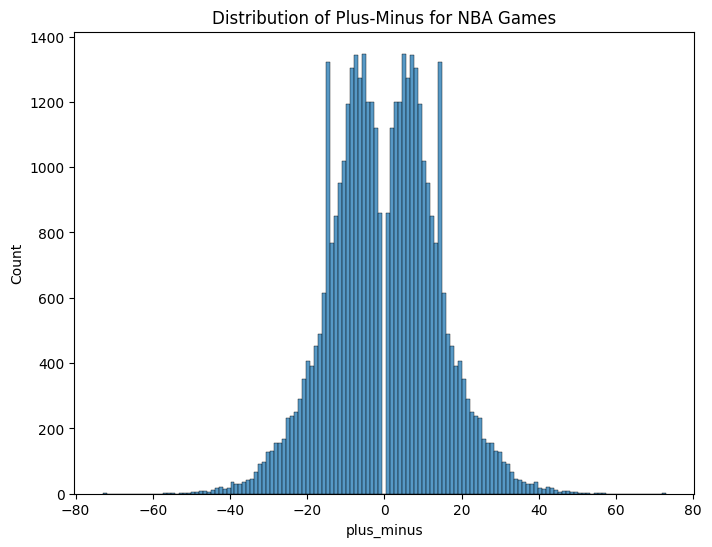

In [ ]:
plt.figure(figsize=(8,6))

sns.histplot(game_df["plus_minus"])

plt.title("Distribution of Plus-Minus for NBA Games")


##Intuitive Features

From our general knowledge of basketball, there were some factors that we thought would affect the plus minus of the final game. These factors are 3 pointers attempted (3FGA), free throws attempted (FTA), assists (AST), and the players point variance (Players PT Variance). These all showcase different styles of play. 

3FGA: Today, there is a heavy emphasis on taking large volumes of 3 point shots over 2 point shots, as statistically speaking this leads to more points over the long run. 

FTA: Some players also rely heavily on free throws to make a large portion of their points, to the point where drawing fouls to get free throws is their sugnature move. 

AST: More assists intuitively means that the ball is being passed around more, i.e. the more assists a team has the more their play-style centers around team plays over individual plays.

Players PT Variance: This is another statistics we can use to measure to see if one player is scoring most of the points or if the points are distributed more evenly.

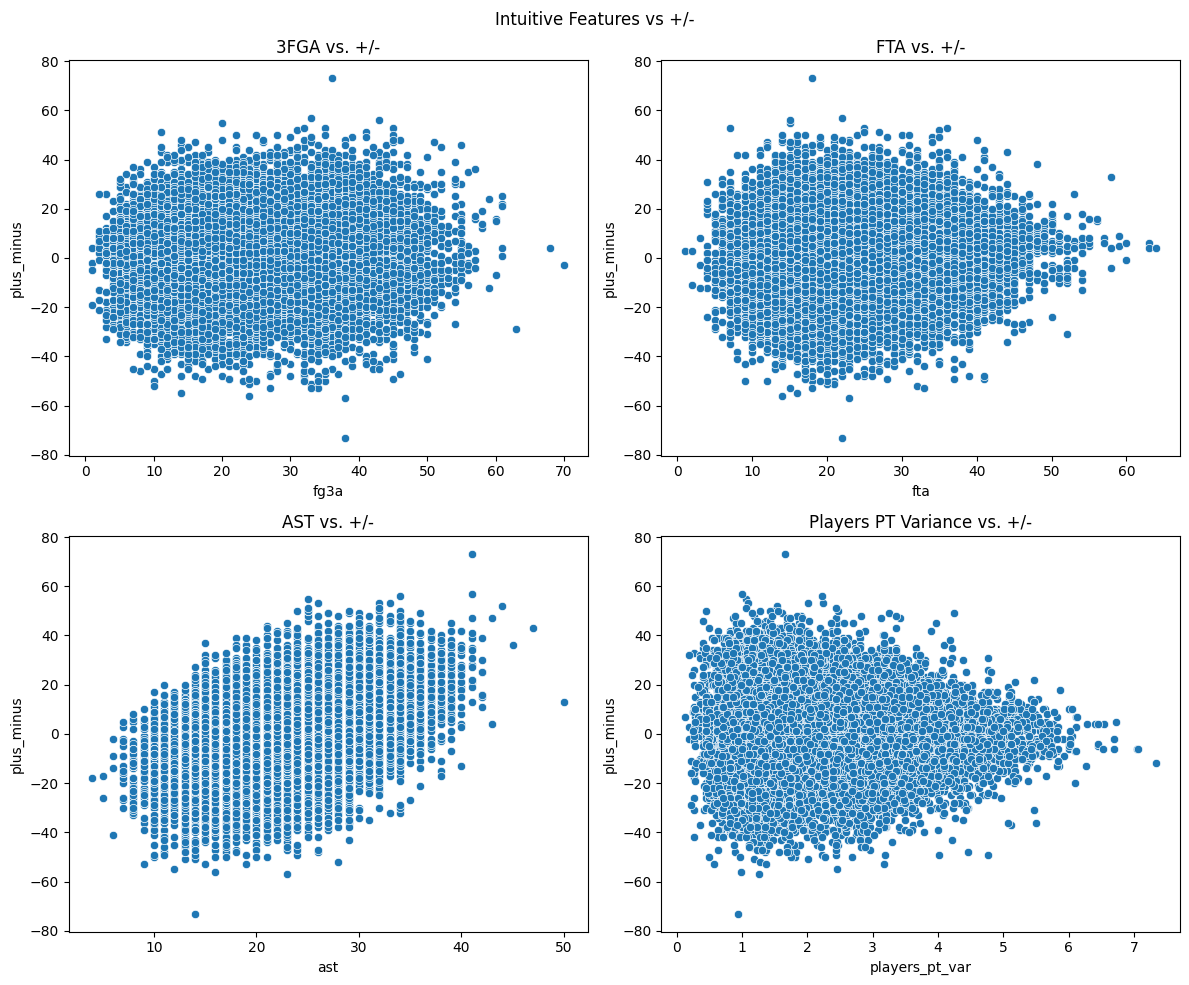

In [ ]:
# scatter plots for more intuitive features
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='fg3a', y='plus_minus', data=game_df, ax=axs[0, 0])
sns.scatterplot(x='fta', y='plus_minus', data=game_df, ax=axs[0, 1])
sns.scatterplot(x='ast', y='plus_minus', data=game_df, ax=axs[1, 0])
sns.scatterplot(x='players_pt_var', y='plus_minus', data=game_df, ax=axs[1, 1])

# titles and labels
axs[0, 0].set_title('3FGA vs. +/-')
axs[0, 1].set_title('FTA vs. +/-')
axs[1, 0].set_title('AST vs. +/-')
axs[1, 1].set_title('Players PT Variance vs. +/-')
fig.suptitle('Intuitive Features vs +/-')
plt.tight_layout()
plt.show()

Our intuition did not serve us as well as we thought it would. In particular, 3 point attempts and free throws attempted are not very correlated with a team's final plus minus. This finding is interesting, and suggests that the modern styles of prioritizing the 3 point or drawing fouls are not as viable as media makes it out to be. 

On the other hand, assists and player point variance do have some correlation with the plus minus. Assists have a strong positive correlation, implying that more assists equals more points. In a way, this correlation may be influenced by the fact that assists can only be counted on shots that counted, i.e. went in for points. Thus, it's correlation is more of an overlap. We had originally wanted to see if more assists led to more points due to a higher level of team play. The variance plot is also quite interesting. The less variance in the players points variance, the more volatile the plus minus score is likely to be. As you increase the players point variance, the more stable the plus minus score becomes. This implies that teams with their points spread evenly tend to lose by a lot or win by a lot, while teams with their points spread apart tend to have close games. 

##Correlation Matrix

After looking at the plots that capture our intuition, let us plot a heat map to see what what features the data tell us are correlated with the plus minus score. 

<ipython-input-52-1e9040408c25>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = game_df.corr()


Text(0.5, 1.0, 'Heat Map')

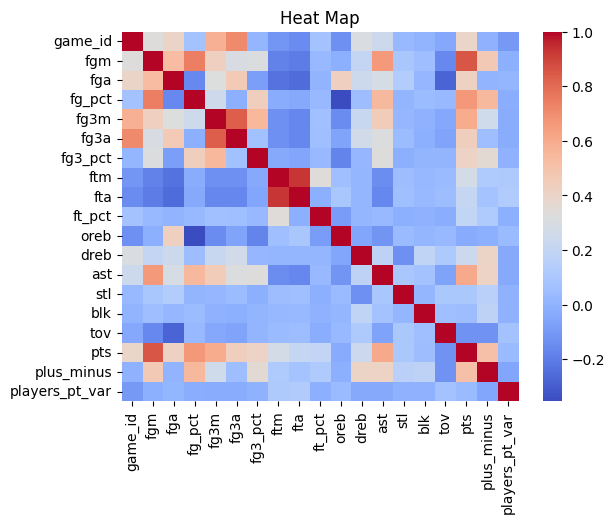

In [ ]:
# correlation matrix
corr = game_df.corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Heat Map')

The heat map tells us that the factors that most influence the plus minus score are the following: 
*   Field goals made (fgm_home)
*   Field goal percentage (fg_pct_home)
*   3 Point Percentage (fg3_pct_home)
*   Defensive Rebounds (dreb_home)
*   Assists (ast_home)
*   Points (pts_home)

An interesting point here is that defensive rebounds are much more correlated with the plus minus score than offensive rebounds. This is explored in the next section.

##Correlated Features

We have already explored the assists correlation in our intuition section, and clearly points will overlap in its correlation with the point plus minus, thus, let us graph the other four features. 



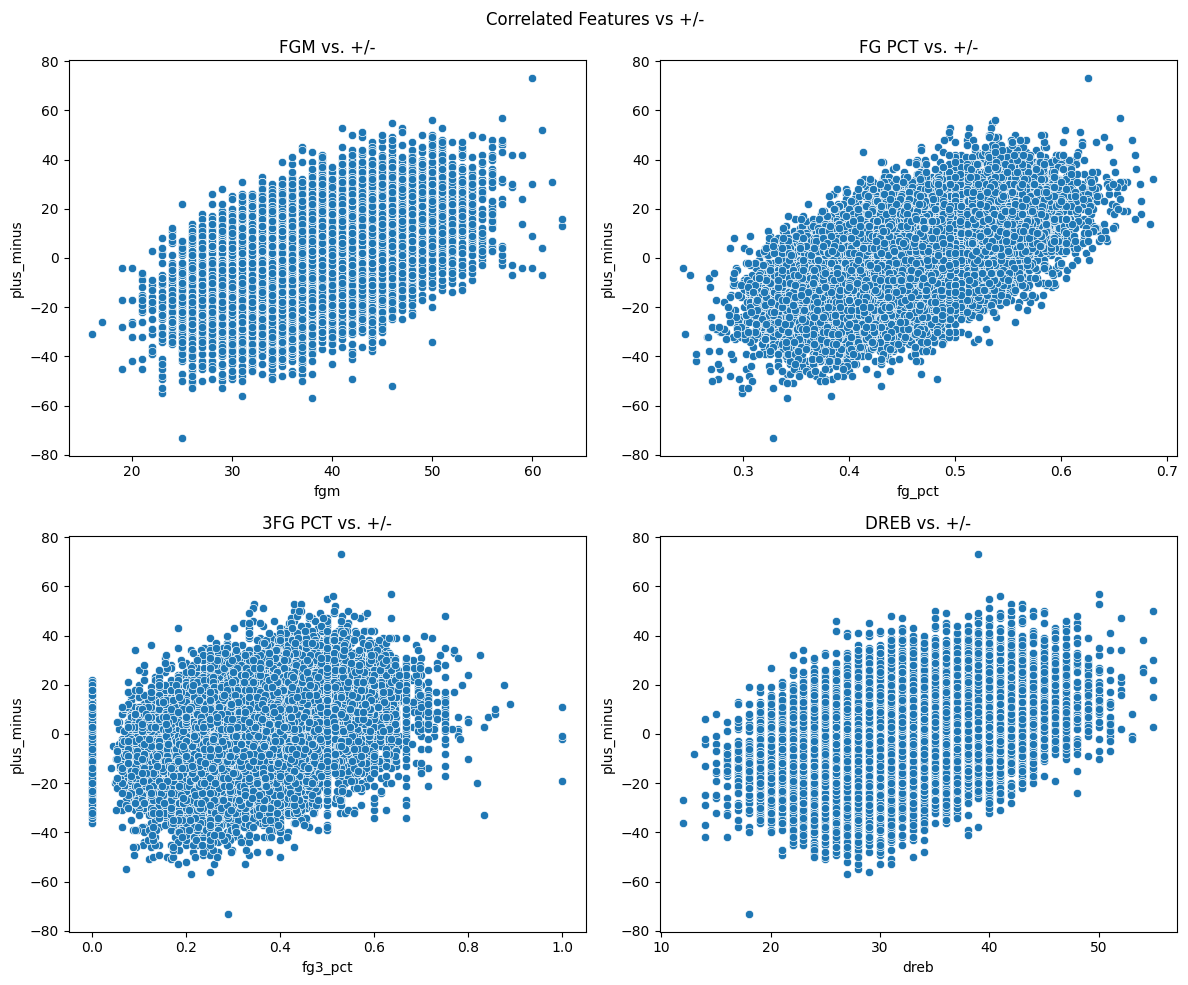

In [ ]:
# scatter plots for correlated features
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='fgm', y='plus_minus', data=game_df, ax=axs[0, 0])
sns.scatterplot(x='fg_pct', y='plus_minus', data=game_df, ax=axs[0, 1])
sns.scatterplot(x='fg3_pct', y='plus_minus', data=game_df, ax=axs[1, 0])
sns.scatterplot(x='dreb', y='plus_minus', data=game_df, ax=axs[1, 1])

# titles and labels
axs[0, 0].set_title('FGM vs. +/-')
axs[0, 1].set_title('FG PCT vs. +/-')
axs[1, 0].set_title('3FG PCT vs. +/-')
axs[1, 1].set_title('DREB vs. +/-')
fig.suptitle('Correlated Features vs +/-')
plt.tight_layout()
plt.show()

From these scatterplots we can notice that all of the features (Field Goals Made, Field Goal Percent, 3Pt Field Goal Percent, and Defensive Rebounds) have a noticeably positive relationship with the point differential of the game.

##A Closer Look at Rebounding: Offensive vs Defensive Rebounds

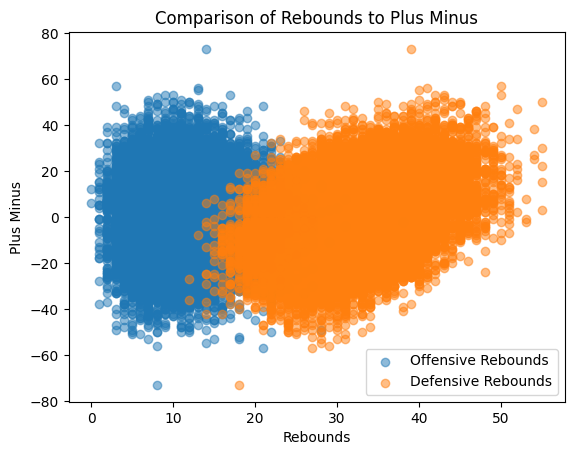

In [ ]:
# scatter plot
plt.scatter(game_df['oreb'], game_df['plus_minus'], label='Offensive Rebounds', alpha=0.5)
plt.scatter(game_df['dreb'], game_df['plus_minus'], label='Defensive Rebounds', alpha=0.5)

# axis labels and title
plt.xlabel('Rebounds')
plt.ylabel('Plus Minus')
plt.title('Comparison of Rebounds to Plus Minus')

# legend
plt.legend()

# plot
plt.show()

This plot seems to demonstrate that defensive rebounds have a  noticeable positive relationship with the team's plus/minus, which essentially means that teams that grab more defensive rebounds tend to have a better point differential in games. The same trend is not necessarily seen, at least to the same extent, in the offensive rebound plot.

##A Closer Look at the 3 Point Shot

One of the big trends that's often talked about in basketball is the increase in 3 point attempts in recent years. We wanted to visualize this trend. The plot below shows how the yearly average for 3 point field goals attempted has dramatically increased over time. This increase in 3 pointers has been associated with an increase in leaguewide offensive efficiency and scoring. Future analyses could explore how this change in 3 point shooting tendencies has altered the formula for how a dominant team performs. 

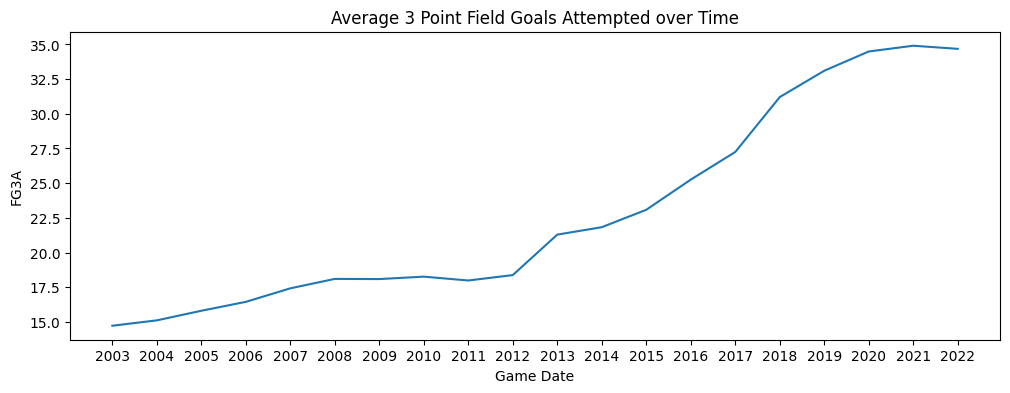

In [ ]:
# time plot

year_avg_df = game_df
year_avg_df["year"] = year_avg_df['game_date'].dt.year
year_avg_df = year_avg_df.groupby('year')['fg3a'].mean()


plt.figure(figsize = (12,4))
plt.plot(year_avg_df.index, year_avg_df.values)

# axis labels and title
plt.xlabel('Game Date')
plt.ylabel('FG3A')
plt.title('Average 3 Point Field Goals Attempted over Time')
plt.xticks(year_avg_df.index)


# plot
plt.show()


# Feature Engineering

##Classification Feature Engineering
In this portion we prepare our feature columns and target columns for the classification task of predicitng the game's winner. Again, information on team name, abbreviation, game id, and game date are not features that we want to include in our features. We also want to drop the wl column since that is the target variable. The plus-minus is always negative for losses and always positive for wins and would thus give a lot of information to the model, so we need to drop that column as well. Our goal is to see if we can use information on team and player statistics to predict the point-differential without knowing anything about the outcome of the game.



In [ ]:
clfeatures = game_df.drop(labels = ["team_abbreviation","team_name", "game_id", "game_date", "wl", "plus_minus", "year"], axis=1)
clfeatures.head(5)

,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,ast,stl,blk,tov,pts,players_pt_var
0,33.0,75.0,0.440,7.0,20.0,0.350,16.0,30.0,0.533,12.0,27.0,25.0,12.0,3.0,8.0,89,1.618182
1,31.0,73.0,0.425,1.0,10.0,0.100,20.0,26.0,0.769,7.0,31.0,20.0,8.0,11.0,20.0,83,1.500000
2,45.0,89.0,0.506,7.0,20.0,0.350,12.0,20.0,0.600,7.0,39.0,32.0,7.0,6.0,10.0,109,1.733333
3,38.0,85.0,0.447,1.0,6.0,0.167,18.0,28.0,0.643,15.0,32.0,26.0,8.0,5.0,8.0,95,2.277778
4,34.0,80.0,0.425,2.0,12.0,0.167,20.0,25.0,0.800,12.0,33.0,17.0,2.0,4.0,12.0,90,2.277778


In [ ]:
def cl_func(row):
  if row['wl'] == 'W':
    return 1
  else:
    return 0
cltarget = game_df.apply(cl_func, axis = 1)
print(cltarget)

0        1
1        1
2        1
3        1
4        1
        ..
44023    1
44024    0
44025    0
44026    0
44027    0
Length: 44028, dtype: int64


## Regression Feature Engineering

Here we prepare our feature columns and target columns for the regression task of predicitng the game's plus-minus. Again, information on team name, abbreviation, game id, and game date are not features that we want to include in our features. We also want to drop the plus minus since that is the target variable. Finally, we dont want to include wl_home since knowing the outcome of the game will provide the model with information on whether the point differential is positive or negative. Our goal is to see if we can use information on team and player statistics to predict the point-differential without knowing anything about the outcome of the game.

In [ ]:
regfeatures = game_df.drop(labels = ["team_abbreviation","team_name", "game_id", "game_date", "wl", "plus_minus", "year"], axis=1
                        )
regfeatures.head(5)

,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,ast,stl,blk,tov,pts,players_pt_var
0,33.0,75.0,0.440,7.0,20.0,0.350,16.0,30.0,0.533,12.0,27.0,25.0,12.0,3.0,8.0,89,1.618182
1,31.0,73.0,0.425,1.0,10.0,0.100,20.0,26.0,0.769,7.0,31.0,20.0,8.0,11.0,20.0,83,1.500000
2,45.0,89.0,0.506,7.0,20.0,0.350,12.0,20.0,0.600,7.0,39.0,32.0,7.0,6.0,10.0,109,1.733333
3,38.0,85.0,0.447,1.0,6.0,0.167,18.0,28.0,0.643,15.0,32.0,26.0,8.0,5.0,8.0,95,2.277778
4,34.0,80.0,0.425,2.0,12.0,0.167,20.0,25.0,0.800,12.0,33.0,17.0,2.0,4.0,12.0,90,2.277778


In [ ]:
regtarget = game_df["plus_minus"]

# Modeling

##**Classification**: Predicting Win or Loss

Before we try to predict the plus-minus of the game, we first want to see if we can use the team's statistics to predict if the team won or lost. 

###Metrics used to Evaluate Model
To evaluate the performance of our classification models, we will use 4 separate metrics: accuracy, precision, recall, and confusion matrices

**Accuracy** measures the overall correctness of the model's predictions. It is calculated by totalling the number of correct predictions and dividing that by the total number of predictions

**Precision** measures the proportion of true positive predictions among all of the positive predictions. It is calculated by totalling the number of true positive predictions and dividing that by the sum of the total number of true positive predictions and the total number of false positive predictions

**Recall** measures the proportion of true positive predictions among all of the positive samples. It is calculated by totalling the number of true positive predictions and dividing that by the sum of the total number of true positive predictions and the total number of false negative predictions.

A **confusion Matrix** visualizes the numnber of true positive, false positive, false negative, and true negative predictions in the data.

###Testing and Training Split
Let's prepare the testing and training splits for the data

In [ ]:
x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(clfeatures, cltarget, test_size = 0.25)

###Classification Models: Logistic Regression
Let's begin our testing with Logistic Regression as our base model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix

log_reg = LogisticRegression(max_iter = 20000)

log_reg = log_reg.fit(x_train_cl, y_train_cl)

y_pred_log = log_reg.predict(x_test_cl)

log_acc_cl = log_reg.score(x_test_cl, y_test_cl)

log_confusion_cl = confusion_matrix(y_test_cl, y_pred_log)

log_precision_cl = precision_score(y_test_cl, y_pred_log)

log_recall_cl = recall_score(y_test_cl, y_pred_log)

print("Accuracy: ", log_acc_cl, ", Precision: ", log_precision_cl, ", Recall: ", log_recall_cl)

Accuracy:  0.8438266557645135 , Precision:  0.8467905094721354 , Recall:  0.838615664845173


####Confusion Matrix Visualization: Logistic Regression
Next, we will create a heatmap to visualize the confusion matrix created in the previous step

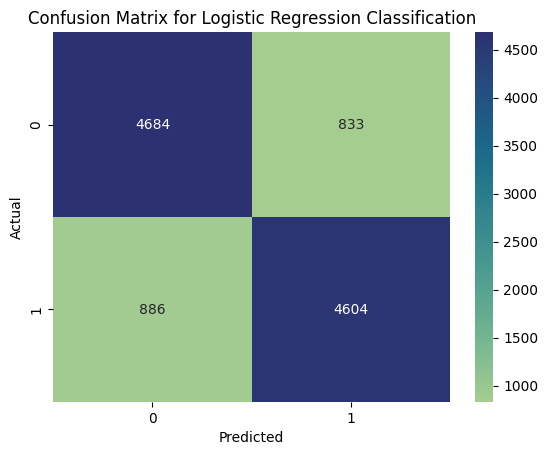

In [ ]:
sns.heatmap(log_confusion_cl, annot = True, cmap = 'crest', fmt = 'd')
plt.title('Confusion Matrix for Logistic Regression Classification')
plt.xlabel('Predicted') 
plt.ylabel('Actual')

plt.show()

###Classification Models: Random Forest Classifier
While the accuracy, precision and recall of the logistic regression model were relatively high, we hope to improve upon these values using the Random Forest Classifier model. The Random Forest Classifier model is advantageous in that it can control for outliers more easily and is overall less sensitive to outlying values than logistic regression models.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rand_forest_model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 30)

rand_forest_model.fit(x_train_cl, y_train_cl)
y_pred_rf = rand_forest_model.predict(x_test_cl)

rf_acc_cl = accuracy_score(y_test_cl, y_pred_rf)

rf_confusion_cl = confusion_matrix(y_test_cl, y_pred_rf)

rf_precision_cl = precision_score(y_test_cl, y_pred_rf)

rf_recall_cl = recall_score(y_test_cl, y_pred_rf)

print("Accuracy: ", rf_acc_cl, ", Precision: ", rf_precision_cl, ", Recall: ", rf_recall_cl)

Accuracy:  0.7988552739165985 , Precision:  0.8016574585635359 , Recall:  0.7928961748633879


Each of the metrics for the random forest model are very similar to those of the logistic regression model, but they are each slightly lower.

####Confusion Matrix Visualization: Random Forest
Let's create a heatmap to visualize the confusion matrix created in the previous step.

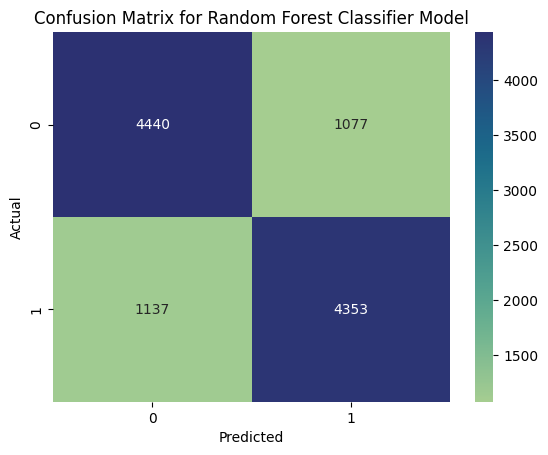

In [ ]:
sns.heatmap(rf_confusion_cl, annot = True, cmap = 'crest', fmt = 'd')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.xlabel('Predicted') 
plt.ylabel('Actual')

plt.show()

The accuracy, precision, and recall of the Random Forest model seem to be lower than the Logistic Regression. One reason for this may be that the data is linearly separable, which is more suited to the logistic regression model. Additionally, the dataset could be imbalanced, meaning one class has significantly fewer samples than the other, which again, favors the logistic regression model.

###Principal Component Analysis (PCA)
We will now perform a principal component analysis to reduce the dimensionality of our features. We will accomplish this by first finding the optimal number of Principal Components to choose for our model by graphing the cumulative explained variance ratio against the number of components used in the model. Using 90% variance as a threshold, we will find the optimal number of components for our model and will then run another logistic regression after the PCA to try and achieve higher precision, accuracy, and recall than our previous models.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ss = StandardScaler()
ss.fit(x_train_cl)
X_train_scale_cl = ss.transform(x_train_cl)
X_test_scale_cl = ss.transform(x_test_cl)
pca_cl = PCA()
pca_train_cl = pca_cl.fit(X_train_scale_cl)

explained_variance_ratios_cl = pca_cl.explained_variance_ratio_
cum_evr_cl = np.cumsum(explained_variance_ratios_cl)


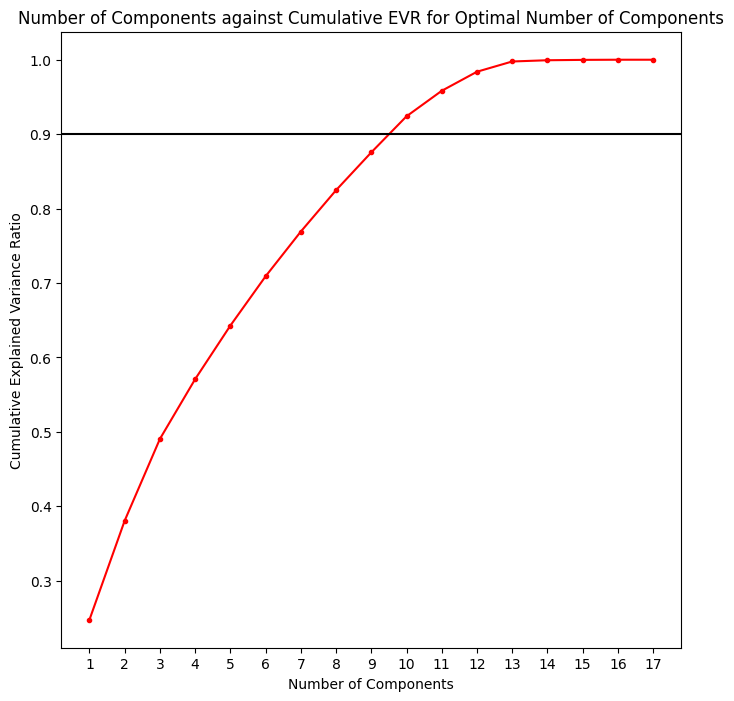

In [ ]:
plt.figure(figsize= (8,8))
cum_evr_length = len(cum_evr_cl) + 1
plt.plot(range(1, cum_evr_length), cum_evr_cl, marker = '.', color = 'r')
plt.axhline(y = 0.9, color = 'k')
plt.xticks(range(1,18))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Number of Components against Cumulative EVR for Optimal Number of Components')

plt.show()

From the graph, we are able to determine that 10 components is the closest number of components to account for around 90% of the variance, so we determine that 10 is the optimal number of principle components. We then change the number of components in the data to 10 and run the logistic regression again on the adjusted data in hopes of obtaining higher accuracy, precision, and recall in the classification model.

In [ ]:
pca_v2_cl = PCA(n_components= 10)
X_train_pca_cl = pca_v2_cl.fit_transform(X_train_scale_cl)
X_test_pca_cl = pca_v2_cl.transform(X_test_scale_cl)
log_reg_pca = LogisticRegression()
log_reg_pca = log_reg_pca.fit(X_train_pca_cl, y_train_cl)

y_pred_pca_cl = log_reg_pca.predict(X_test_pca_cl)

test_accuracy_pca_cl = log_reg_pca.score(X_test_pca_cl, y_test_cl)
pcalog_confusion_cl = confusion_matrix(y_test_cl, y_pred_pca_cl)

pcalog_precision_cl = precision_score(y_test_cl, y_pred_pca_cl)

pcalog_recall_cl = recall_score(y_test_cl, y_pred_pca_cl)

print("Accuracy: ", test_accuracy_pca_cl, ", Precision: ", pcalog_precision_cl, ", Recall: ", pcalog_recall_cl)

Accuracy:  0.7494321795221223 , Precision:  0.7500915415598682 , Recall:  0.7462659380692167


The metrics for this model in each category are by far the lowest of the 3 classification models tested.

####Confusion Matrix Visualization: PCA Logistic Regression
Let's create a heatmap to visualize the confusion matrix created in the previous step.

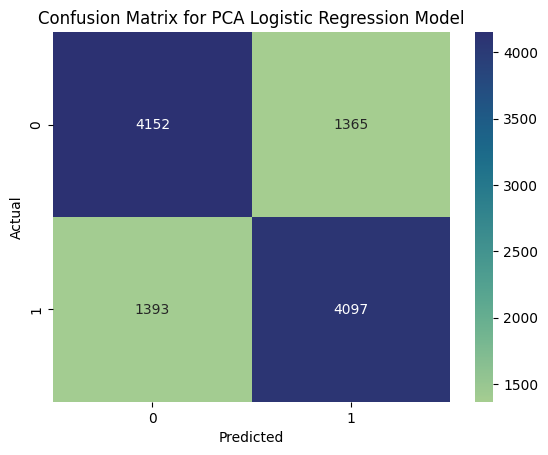

In [ ]:
sns.heatmap(pcalog_confusion_cl, annot = True, cmap = 'crest', fmt = 'd')
plt.title('Confusion Matrix for PCA Logistic Regression Model')
plt.xlabel('Predicted') 
plt.ylabel('Actual')

plt.show()

After testing the Logistic Regression after performing a PCA, the accuracy, precision, and recall were all much lower than the previous Logistic Regression classification model we ran. This could be because in reducing the number of components in the analysis, we could have lost valuable information from the removed features that improved the model's accuracy, precision and recall.

## **Regression**: Predicting Game Plus-Minus

###Metrics Used to Evaluate Models

To evaluate the performance of our regression models, we will use two metrics: R^2 and Root Mean Squared Error(RMSE).

R-squared (R^2) is a statistical measure that represents the proportion of the variance in the dependent variable that is explained by the independent variables in a linear regression model. In other words, R2 provides an indication of how well the model fits the data. An R^2 value of  0 indicates that the model does not explain any of the variability in the dependent variable, and a value of 1 indicates that the model explains all of the variability in the dependent variable. 

Root Mean Squared Error (RMSE) is another commonly used evaluation metric in regression analysis. RMSE measures the square root of the average of the squared differences between the predicted values and the actual values. RMSE is a measure of the average magnitude of the error between the predicted and actual values, and is therefore a useful metric for evaluating the predictive accuracy of a model.

While R^2 provides information about the goodness of fit of the model, RMSE provides information about the accuracy of the model's predictions. Using these 2 measures in conjuction will provide a better understanding of how our models perform. 






###Training and Testing Split

First, let's prepare the training and testing splits for our data. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(regfeatures, regtarget, test_size = 0.25)


###Base Model: Linear Regression

To begin our modeling, we will first train a regular linear regression model on the training data and evaluate its goodness of fit and predictive accuracy. 

In [ ]:
#Create a Linear Regression model and train it.
model = LinearRegression().fit(X_train, y_train)

#Generate model's predictions on test data.
y_pred = model.predict(X_test)

#Find R^2 Score
lin_reg_R2 = model.score(X_test, y_test)

#Find RMSE 
lin_reg_rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R^2: ", lin_reg_R2, " RMSE:", lin_reg_rmse)

R^2:  0.6913262500678794  RMSE: 7.589661591480354


We can see that the model is mediocre at predicting the game's plus-minus based on the features. The R^2 of 0.69 indicates that our model achieves a moderately good fit of the plus-minus data. The RMSE value leaves room for improvement. A difference of 7.5 in plus-minus is pretty significant when it comes to classifying how close a game was. For example, a final plus-minus of 3 points would consitute a close game, whereas a final plus-minus of 11 points would typically mean that one team won by a fairly comfortable margin. However, it's also not unheard of for a game to be close for most of the game only for a team to go on a late double digit run that extends their lead to 10+ points in the final minutes of a game. Thus, the RMSE is decent when put into context. However, this model is not at the level of predictive accuracy that we want. 

###Ridge Regression

Sometimes, multicollinearity can make a standard linear regression model's estimates of the regression coefficients unstable and/or unreliable, which can lead to overfitting and poor predictive performance. Ridge regression is one way to address the issue of multicollinearity. It introduces a penalty term that can reduce the magnitude of regression coefficients toward zero, but it doesn't set any of them to exactly zero, so all of our features will still be retained in the model. 

Although our EDA did not show a high degree of correlation among the feature variables, it's worth exploring if the Ridge Regression can produce better predictive results. Ridge regression uses a regularization parameter. We will use GridsearchCV for hyperparameter tuning which will allow us to select the optimal value for this regularization parameter. 

In [ ]:
#The data first has to be scaled before using Ridge Regression
scaler = StandardScaler()

scaler.fit(X_train)

scaled_x_train = scaler.transform(X_train)
scaled_x_test = scaler.transform(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
import math
ridgeModel = Ridge()

# Define the hyperparameters to tune
hyperparameters = {'alpha': [0.01, 0.1, 0.5, 0.75, 0.99,1, 1.01, 1.02, 1.05, 1.1, 1.2, 1.3, 1.5, 2, 3, 5, 10, 100]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ridgeModel, param_grid=hyperparameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(scaled_x_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'alpha': 3}


In [ ]:
#Train our ridge model using our optimaly alpha value
ridgeModel = Ridge(alpha = 3).fit(scaled_x_train, y_train)

y_pred = ridgeModel.predict(scaled_x_test)

ridge_R2 = ridgeModel.score(scaled_x_test, y_test)
ridge_rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R^2: ", ridge_R2, " RMSE:", ridge_rmse)

R^2:  0.6913217589788178  RMSE: 7.589716804666087


Our Ridge Regression model's performance is about the same as our original Linear Regression model. This could be due to the fact that there wasn't a high degree of collinearity to begin with. 

###PCA for Dimensionality Reduction

Another method to reduce the problem of multicollinearity, as well as reduce the dimensionality of the features is PCA. PCA transforms the original variables into principal components, which are linear combinations of the original variables. The first principal component is chosen to have the maximum possible variance, and each subsequent principal component is chosen to have the maximum possible variance subject to the constraint that it is orthogonal to the previous components. The resulting principal components are uncorrelated and sorted by the amount of variance they explain in the original data.



In [ ]:
#Instantiate and Fit PCA
pca = PCA()
pca_x_train = pca.fit_transform(scaled_x_train)

#Save the explained variance ratios 

explained_variance_ratios = pca.explained_variance_ratio_
#Save the cumulative explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(pca.explained_variance_ratio_)

Text(0.5, 1.0, 'Explained Variance Ratio vs Number of Components')

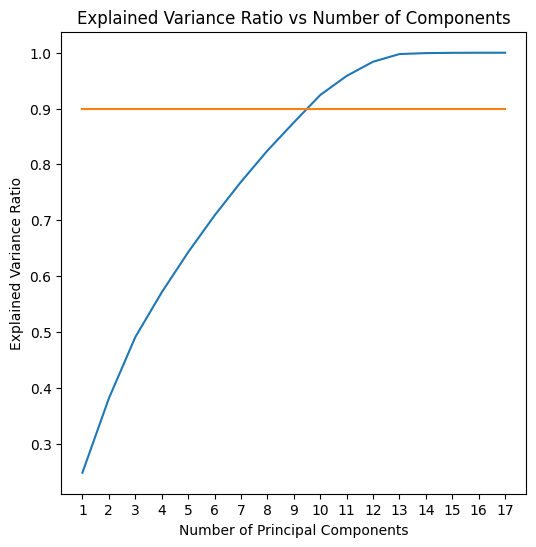

In [ ]:
# Find optimal num components to use (n) by plotting explained variance ratio 
plt.figure(figsize=(6,6))
plt.plot(np.arange(0,17), cum_evr)
plt.xticks(range(0,17), range(1,18)) 
plt.plot(np.arange(0,17), [0.9]*17)
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components")

We can see from this plot that 10 principle components explain over 90% of the variance. We will use 10 principle components in our ensuing analysis. 

In [ ]:
#Instantiate PCA with 8 principle components
pca = PCA(n_components=10)
pca_x_train = pca.fit_transform(scaled_x_train)


#Transform on Testing Set
X_test_pca = pca.transform(scaled_x_test)


###Linear Regression Using PCA features

Here, we explore the use of our PCA principal components as features for our Linear regression models. PCA can help address issues of multicollinearity. 

In [ ]:
#Create a Linear Regression model and train it.
model_pca_lr = LinearRegression().fit(pca_x_train, y_train)

#Generate model's predictions on test data.
y_pred_pca_lr = model_pca_lr.predict(X_test_pca)

#Find R^2 Score
lin_reg_R2_pca = model_pca_lr.score(X_test_pca, y_test)

#Find RMSE 
lin_reg_rmse_pca = mean_squared_error(y_test, y_pred_pca_lr, squared=False)

print("R^2: ", lin_reg_R2_pca, " RMSE:", lin_reg_rmse_pca)

R^2:  0.41934494605065453  RMSE: 10.409543111556589


The resulting model's performance is significantly worse than the original linear regression model. This is likely due to the fact that by doing PCA, we eliminated some of the information that was present in the original features. Although, 10 principal components are able to capture 90% of the variation in the original data, evidently, this was not enough to maintain the model's performance. 

###Random Forest Regression

Linear regression works well when there's a linear relationship between the feature variables and the target. However, it's possible that there are non-linear relationships between our features and the target variable. Random Forest Regressors tend to perform better than linear regression models when there are non-linear relationships between the variables. Random Forest Regressor has several hyperparameters that can be tuned to improve performance. However, because of the amount of time it takes to train the Random Forest Regressor, the hyperparameter tuning ended up taking too much time to be feasible. We also explore using PCA to reduce the dimensionality prior to training in hopes of reducing training time. 

In [ ]:
#Fit our random forest regressor using the identified hyperparameters
rfReg = RandomForestRegressor(n_estimators=200).fit(X_train, y_train)

y_pred_rf = rfReg.predict(X_test)

#Find the R-squared score and RMSE
rfr_R2 = rfReg.score(X_test, y_test)
rfr_RMSE = mean_squared_error(y_test, y_pred_rf, squared=False)

print("R^2: ", rfr_R2, " RMSE:", rfr_RMSE)

R^2:  0.6227163052480922  RMSE: 8.390862051488622


The RandomForest Regressor performs worse than our Linear Regression models, showing a lower R^2 and higher RMSE. The training time of the model was also long, which prevented us from doing more extensive hyperparameter tuning to improve the model performance. We explore the use of PCA to reduce the dimensionality of the features, in hopes of reducing the training time, while maintaining similar model performance so that a more extensive hyperparameter tuning can be done with the PCA features.  

In [ ]:
#Fit our random forest regressor on the PCA principle components.
rfRegPCA = RandomForestRegressor(n_estimators=200).fit(pca_x_train, y_train)

y_pred_rf_pca = rfRegPCA.predict(X_test_pca)

# Find the R-squared score and RMSE
rfr_R2_pca = rfRegPCA.score(X_test_pca, y_test)
rfr_RMSE_pca = mean_squared_error(y_test, y_pred_rf_pca, squared=False)

print("R^2: ", rfr_R2_pca, " RMSE:", rfr_RMSE_pca)

R^2:  0.4130111616129384  RMSE: 10.466162768691975


Using PCA to reduce the dimensionality prior to training the random forest did not yield the desired results. The training time did not go down, and both the R^2 and RMSE became significantly worse. 

###Support Vector Machine Regression



Support Vector Machines are another machine learning method that can be used for regression. Like RandomForestRegressors, SVMs can also model nonlinear relationships. They are also tunable and robust to outliers. 

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#Instantiate and train the model
svmMod = svm.SVR()
svmMod.fit(scaled_x_train, y_train)

#Predict the test data
y_pred_svm = svmMod.predict(scaled_x_test)

# Find the R-squared score and RMSE
svm_score = svmMod.score(scaled_x_test, y_test)

svm_RMSE = mean_squared_error(y_test, y_pred_svm, squared=False)
print("R^2: ", svm_score, " RMSE:", svm_RMSE)

R^2:  0.6829767216646709  RMSE: 7.788265802330863


The Support Vector Machine Regression model's performance is closer to the original linear regression model compared to the random forest regressor, but it is still slightly worse than the base model. It is possible, however, that this model's performance could be improved further through more rigorous hyperparameter tuning. We originally set out to do a more extensive tuning process, but found that the time it took was prohibitively long. Future analyses could harness the power of distributed computing and more powerful processers to tune the model in a more efficient manner.

##Regression Conclusions

Overall, the performance of our models is disappointing when it comes to predicting the plus-minus of a game based on one of the team's performance. However, this is not surprising because our feature set only included information on an individual team's performance. Our models had little to no information on how the opposing team performed. At the end of the day, there are 2 teams in every NBA game and there's only so much that's within a team's control when it comes to winning games. A team can have a lights out shooting performance but they can still lose if the opposing team had an even better offensive performance. 

One of the reasons that we didn't include the other team's full box score as features is that we felt that if we included information such as the other team's fgm, 3 pointers made, and free throws made, you'd have enough information to just reconstruct the final plus-minus by calculating how many points each team scored. Any finer nuances regarding the team's shot diet, rebounding tendencies, and ball movement would not factor in to the models as much. Our hopes for this project were to explore how a team's performance and strategy affect the outcome of the game since these are the parts of the game that they can control. 

Something that could be incorporated into future models is advanced statistics that capture a team's defensive performance in a more nuanced way than blocks and steals. With the tracking data and advanced metrics available now, it's possible to quantify aspects of a team's defensive performance such as percentage of opponents' shots contested, turnovers foced, quality of shots conceded, or defensive formations. Such statistics tell more about a team's defensive performance. By incorporating such information, our models would be able to incorporate information on how well a team defended, which unlike opponent field goal percentage, is something that is in a team's control. 

Another way to improve our regression models' performance would have been to do more extensive hyperparameter tuning, expecially with the random forest regressor and the support vector machine. However, due to computational constraints, we were not able to do as much tuning as we would have liked with these models. 